In [3]:
import pandas as pd, numpy as np
import os, sys, glob, re
from pathlib import Path
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from sas7bdat import SAS7BDAT

In [4]:
# Set max columns in Jupyter Notebooks
pd.set_option("display.max_columns", None)

# Convert 13f from .sas7bdat to .csv

In [2]:
inputfilepath = Path(r"C:\Users\jasonjia\Dropbox\Projects\boardex_and_execucomp\data\13f\13f_refinitiv_rdate_202110-202112.sas7bdat")
outputfilepath = Path(r"C:\Users\jasonjia\Dropbox\Projects\boardex_and_execucomp\output\13f\13f_refinitiv_rdate_202110-202112.csv")

In [3]:
# Import files
with SAS7BDAT(str(inputfilepath)) as reader:
    df = reader.to_data_frame()
df.head(1)

,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,...,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2
0,7375.0,22645.0,MA INVESTMENT PARTNERSHIP LP,4.0,UNITED STATES,22553.0,22645.0,,,,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.to_csv(outputfilepath, index=False)

# Part 2

## Import file and do basic checks

In [46]:
inputfilepath = Path(r"C:\Users\jasonjia\Dropbox\Projects\boardex_and_execucomp\output\13f\13f_refinitiv_rdate_202110-202112.csv")

In [47]:
# Import files
df = pd.read_csv(inputfilepath)
df.head(1)

,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2
0,7375.0,22645.0,MA INVESTMENT PARTNERSHIP LP,4.0,UNITED STATES,22553.0,22645.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# View dates
# Check that there is only 1 quarter's worth of reported dates
print("View dates:")
print("Unique report dates:", df['RDATE'].unique())
print("Unique file dates:", df['FDATE'].unique())
print("Unique prior report dates:", df['PRDATE'].unique())
assert(len(df['RDATE'].unique()) == 1)
assert(len(df['FDATE'].unique()) == 1)

View dates:
Unique report dates: [22645.]
Unique file dates: [22645.]
Unique prior report dates: [22553.    nan 22461. 22370. 21549. 21274. 22280. 20361. 22188. 20727.
 21914. 20819. 21822. 15340. 18170. 21184. 17805. 21457. 21730. 14609.
 21639. 12053. 17897. 22005. 20088. 21092. 20635. 20544. 21000.]


In [49]:
# View columns
print("Columns:", df.columns)

Columns: Index(['MGRNO', 'RDATE', 'MGRNAME', 'TYPECODE', 'COUNTRY', 'PRDATE', 'FDATE',
       'CUSIP', 'STKNAME', 'TICKER', 'EXCHCD', 'STKCD', 'STKCDESC', 'INDCODE',
       'SHARES', 'NO', 'SHARED', 'SOLE', 'CHANGE', 'PRC', 'SHROUT1',
       'SHROUT2'],
      dtype='object')


In [50]:
# Remove NaNs
print("Number of rows of df before removing NaNs for STKNAME:", df.shape[0])
df = df.mask(df == '')
df = df.dropna(how='any', subset=['STKNAME'])
print("Number of rows of df after removing NaNs for STKNAME:", df.shape[0])

# Replace NaNs with 0 
# So that when grouping by later on, we don't use rows and thus companies without other rows, e.g. ticker.
df = df.fillna(0)

Number of rows of df before removing NaNs for STKNAME: 1727460
Number of rows of df after removing NaNs for STKNAME: 1727434


## Merge df with df_type to get types

In [51]:
# Create a df mapping typecode to actual types
type_dict = {1:'Bank', 2:'Insurance', 3:'Mutual Funds', 4:'Investment Advisors', 5:'Others'}
df_type = pd.DataFrame(list(type_dict.items()), columns = ['TYPECODE','type'])
df_type

,TYPECODE,type
0,1,Bank
1,2,Insurance
2,3,Mutual Funds
3,4,Investment Advisors
4,5,Others


In [52]:
# Merge df with df_type to get types
df = df.merge(df_type, how='left', on='TYPECODE', validate='m:1')
df

,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2,type
0,45495.0,22645.0,HUNTINGTON PRIVATE FINL GROUP,5.0,UNITED STATES,22553.0,22645.0,00088630,COMMSCOPE CONNECTIVITY LLC,0,V,0,COM,108.0,1.0,1.0,0.0,0.0,0.0,12.74,97.0,97156.0,Others
1,8976.0,22645.0,BOSTON PRIVATE WEALTH LLC,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,10749.0,0.0,0.0,10749.0,-360.0,4.77,1108.0,1107985.0,Investment Advisors
2,12864.0,22645.0,CAPTRUST FINANCIAL ADVR,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,399.0,0.0,0.0,399.0,0.0,4.77,1108.0,1107985.0,Investment Advisors
3,14387.0,22645.0,"SUMMIT GLOBAL INVESTMENTS, LLC",4.0,UNITED STATES,22553.0,22645.0,00141921,INVESCO LIMITED TERM MUNI IN,0,0,7,0,0.0,21037.0,0.0,0.0,0.0,21037.0,7.45,0.0,0.0,Investment Advisors
4,10576.0,22645.0,FIRST AMERICAN BANK,5.0,UNITED STATES,22553.0,22645.0,00141G38,INVESCO SHORT DURATION HIGH,0,0,7,0,0.0,10984182.0,658888.0,0.0,10325294.0,355039.0,3.74,0.0,0.0,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727429,81540.0,22645.0,STATE STR CORPORATION,1.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,595542.0,35982.0,0.0,559560.0,6442.0,11.07,33.0,33193.0,Bank
1727430,82810.0,22645.0,TEACHERS ADVR INC,2.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,47376.0,0.0,0.0,47376.0,0.0,11.07,33.0,33193.0,Insurance
1727431,84900.0,22645.0,CITIGROUP INC,5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,15430.0,0.0,0.0,15430.0,4527.0,11.07,33.0,33193.0,Others
1727432,90457.0,22645.0,"VANGUARD GROUP, INC.",5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,1310377.0,1272890.0,37487.0,0.0,-27316.0,11.07,33.0,33193.0,Others


## groupby check

In [53]:
agg_dict = {'SHARES':'mean'}
df_check = df.groupby(['STKNAME', 'RDATE', 'FDATE', 'CUSIP', 'TICKER', 'EXCHCD', 'STKCD', 'STKCDESC', 'INDCODE']).agg(agg_dict).reset_index()
df_check.head(5)

,STKNAME,RDATE,FDATE,CUSIP,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES
0,1-800-FLOWERS.COM INC,22645.0,22645.0,68243Q10,FLWS,V,0,COM,129.0,152370.723757
1,10X CAPITAL VENTURE ACQUISIT,22645.0,22645.0,G8707610,VCXA,I,7,COM,120.0,403411.371429
2,10X CAPITAL VENTURE ACQUISIT,22645.0,22645.0,G8707612,VCXA,I,7,COM,120.0,301097.750000
3,10X GENOMICS INC,22645.0,22645.0,88025U10,TXG,V,0,COM,116.0,200784.377892
4,111 INC,22645.0,22645.0,68247Q10,YI,V,+,AR,108.0,167722.956522


In [54]:
# Check that grouping by didn't remove any company names or CUSIPs
print("Check that grouping by didn't remove any company names or CUSIPs:")
print("Number of unique company names (before groupby):", df['STKNAME'].nunique())
print("Number of unique CUSIPs (before groupby):", df['CUSIP'].nunique())
print("Number of unique company names (after groupby):", df_check['STKNAME'].nunique())
print("Number of unique CUSIPs (after groupby):", df_check['CUSIP'].nunique())
assert(df['STKNAME'].nunique() == df_check['STKNAME'].nunique())
assert(df['CUSIP'].nunique() == df_check['CUSIP'].nunique())

Check that grouping by didn't remove any company names or CUSIPs:
Number of unique company names (before groupby): 13479
Number of unique CUSIPs (before groupby): 15730
Number of unique company names (after groupby): 13479
Number of unique CUSIPs (after groupby): 15730


## groupby1

In [55]:
# For each firm, get total number of shares held by each manager in the dataset. 
# RDATE not necessary but put in case we want to scale to multiple time periods
df['sum'] = df.groupby(['STKNAME', 'CUSIP', 'RDATE'])['SHARES'].transform('sum')

# Get % shares owned by each manager, out of all outstanding shares
df['pct'] = df['SHARES'] / (df['SHROUT2'] * 1000)
df

,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2,type,sum,pct
0,45495.0,22645.0,HUNTINGTON PRIVATE FINL GROUP,5.0,UNITED STATES,22553.0,22645.0,00088630,COMMSCOPE CONNECTIVITY LLC,0,V,0,COM,108.0,1.0,1.0,0.0,0.0,0.0,12.74,97.0,97156.0,Others,1.0,1.029273e-08
1,8976.0,22645.0,BOSTON PRIVATE WEALTH LLC,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,10749.0,0.0,0.0,10749.0,-360.0,4.77,1108.0,1107985.0,Investment Advisors,11148.0,9.701395e-06
2,12864.0,22645.0,CAPTRUST FINANCIAL ADVR,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,399.0,0.0,0.0,399.0,0.0,4.77,1108.0,1107985.0,Investment Advisors,11148.0,3.601132e-07
3,14387.0,22645.0,"SUMMIT GLOBAL INVESTMENTS, LLC",4.0,UNITED STATES,22553.0,22645.0,00141921,INVESCO LIMITED TERM MUNI IN,0,0,7,0,0.0,21037.0,0.0,0.0,0.0,21037.0,7.45,0.0,0.0,Investment Advisors,21037.0,inf
4,10576.0,22645.0,FIRST AMERICAN BANK,5.0,UNITED STATES,22553.0,22645.0,00141G38,INVESCO SHORT DURATION HIGH,0,0,7,0,0.0,10984182.0,658888.0,0.0,10325294.0,355039.0,3.74,0.0,0.0,Others,10984182.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727429,81540.0,22645.0,STATE STR CORPORATION,1.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,595542.0,35982.0,0.0,559560.0,6442.0,11.07,33.0,33193.0,Bank,11085482.0,1.794179e-02
1727430,82810.0,22645.0,TEACHERS ADVR INC,2.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,47376.0,0.0,0.0,47376.0,0.0,11.07,33.0,33193.0,Insurance,11085482.0,1.427289e-03
1727431,84900.0,22645.0,CITIGROUP INC,5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,15430.0,0.0,0.0,15430.0,4527.0,11.07,33.0,33193.0,Others,11085482.0,4.648570e-04
1727432,90457.0,22645.0,"VANGUARD GROUP, INC.",5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,1310377.0,1272890.0,37487.0,0.0,-27316.0,11.07,33.0,33193.0,Others,11085482.0,3.947751e-02


In [56]:
# Note: There are cases where the shares owned by a manager exceeds that of the "total number of shares"
# This is a problem that needs to be resolved later. 
# https://wrds-www.wharton.upenn.edu/pages/support/support-articles/thomson-reuters/institutional-holdings-s34/
print("Problem to be resolved: there are cases where the shares owned by a manager exceeds that of the 'total number of shares'")
df[(df['pct'] > 1) & (df['pct'] < 1000000000)]

Problem to be resolved: there are cases where the shares owned by a manager exceeds that of the 'total number of shares'


,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2,type,sum,pct
3298,6122.0,22645.0,"ALTRINSIC GLOBAL ADVISORS, LLC",5.0,UNITED STATES,22553.0,22645.0,24661P80,DELCATH SYSTEMS INC,0,0,0,COM,116.0,90000.0,0.0,0.0,90000.0,10000.0,10.00,0.0,73.0,Others,1309275.0,1.232877
3306,11952.0,22645.0,CIBC WORLD MARKETS INC.,5.0,CANADA,22553.0,22645.0,24661P80,DELCATH SYSTEMS INC,0,0,0,COM,116.0,85319.0,0.0,0.0,85319.0,85319.0,10.00,0.0,73.0,Others,1309275.0,1.168753
3316,22350.0,22645.0,"DEERFIELD MANAGEMENT CO, L.P.",5.0,UNITED STATES,22553.0,22645.0,24661P80,DELCATH SYSTEMS INC,0,0,0,COM,116.0,500000.0,0.0,0.0,500000.0,0.0,10.00,0.0,73.0,Others,1309275.0,6.849315
3327,90457.0,22645.0,"VANGUARD GROUP, INC.",5.0,UNITED STATES,22553.0,22645.0,24661P80,DELCATH SYSTEMS INC,0,0,0,COM,116.0,341295.0,340538.0,757.0,0.0,92806.0,10.00,0.0,73.0,Others,1309275.0,4.675274
35048,10586.0,22645.0,AMVESCAP PLC LONDON,5.0,UNITED KINGDOM,22553.0,22645.0,00162Q46,ALPS CLEAN ENERGY ETF,ACES,I,7,COM,120.0,6286517.0,509011.0,0.0,5777506.0,89280.0,28.71,5.0,4750.0,Others,9494605.0,1.323477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661403,9715.0,22645.0,SILVERHAWK ASSET MANAGEMENT LL,4.0,UNITED STATES,0.0,22645.0,90214Q10,AFFINITY WORLD LEADERS EQUIT,WLDR,I,7,COM,120.0,455616.0,0.0,0.0,455616.0,455616.0,17.05,0.0,250.0,Investment Advisors,1061913.0,1.822464
1661406,14479.0,22645.0,SOWELL MANAGEMENT SERVICES,4.0,UNITED STATES,22553.0,22645.0,90214Q10,AFFINITY WORLD LEADERS EQUIT,WLDR,I,7,COM,120.0,463969.0,0.0,0.0,463969.0,2404.0,17.05,0.0,250.0,Investment Advisors,1061913.0,1.855876
1709570,11697.0,22645.0,MANAGED ACCT ADVR LLC,4.0,UNITED STATES,22553.0,22645.0,78464A53,SPDR SP TRANSPORTATION ETF,XTN,I,7,COM,120.0,3656856.0,3656856.0,0.0,0.0,3624712.0,43.61,2.0,2050.0,Investment Advisors,6017798.0,1.783832
1709654,67476.0,22645.0,"ORBIMED ADVISORS, LLC",5.0,UNITED STATES,22553.0,22645.0,98420P30,XTANT MEDICAL HOLDINGS INC,XTNT,B,0,COM,116.0,72873494.0,0.0,0.0,72873494.0,0.0,0.67,13.0,13224.0,Others,80663340.0,5.510700


In [57]:
def topy(values, y):
    values = values.sort_values(ascending = False)
    # [:y] gets all values index from 0 to y-1, i.e. the first y values.
    # If there are fewer than y values, all values are selected.
    return sum(values[:y])

In [58]:
# For each firm, get total number of shares held by top y managers in the dataset (top = most number of shares). 
# RDATE not necessary but put in case we want to scale to multiple time periods
df['sum_top1'] = df.groupby(['STKNAME', 'CUSIP', 'RDATE'])['SHARES'].transform(lambda x: topy(x, 1))
df['sum_top5'] = df.groupby(['STKNAME', 'CUSIP', 'RDATE'])['SHARES'].transform(lambda x: topy(x, 5))
df['sum_top10'] = df.groupby(['STKNAME', 'CUSIP', 'RDATE'])['SHARES'].transform(lambda x: topy(x, 10))

# Get corresponding percentages, out of all outstanding shares
df['pct_top1'] = df['sum_top1'] / (df['SHROUT2'] * 1000)
df['pct_top5'] = df['sum_top5'] / (df['SHROUT2'] * 1000)
df['pct_top10'] = df['sum_top10'] / (df['SHROUT2'] * 1000)
df

,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2,type,sum,pct,sum_top1,sum_top5,sum_top10,pct_top1,pct_top5,pct_top10
0,45495.0,22645.0,HUNTINGTON PRIVATE FINL GROUP,5.0,UNITED STATES,22553.0,22645.0,00088630,COMMSCOPE CONNECTIVITY LLC,0,V,0,COM,108.0,1.0,1.0,0.0,0.0,0.0,12.74,97.0,97156.0,Others,1.0,1.029273e-08,1.0,1.0,1.0,1.029273e-08,1.029273e-08,1.029273e-08
1,8976.0,22645.0,BOSTON PRIVATE WEALTH LLC,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,10749.0,0.0,0.0,10749.0,-360.0,4.77,1108.0,1107985.0,Investment Advisors,11148.0,9.701395e-06,10749.0,11148.0,11148.0,9.701395e-06,1.006151e-05,1.006151e-05
2,12864.0,22645.0,CAPTRUST FINANCIAL ADVR,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,399.0,0.0,0.0,399.0,0.0,4.77,1108.0,1107985.0,Investment Advisors,11148.0,3.601132e-07,10749.0,11148.0,11148.0,9.701395e-06,1.006151e-05,1.006151e-05
3,14387.0,22645.0,"SUMMIT GLOBAL INVESTMENTS, LLC",4.0,UNITED STATES,22553.0,22645.0,00141921,INVESCO LIMITED TERM MUNI IN,0,0,7,0,0.0,21037.0,0.0,0.0,0.0,21037.0,7.45,0.0,0.0,Investment Advisors,21037.0,inf,21037.0,21037.0,21037.0,inf,inf,inf
4,10576.0,22645.0,FIRST AMERICAN BANK,5.0,UNITED STATES,22553.0,22645.0,00141G38,INVESCO SHORT DURATION HIGH,0,0,7,0,0.0,10984182.0,658888.0,0.0,10325294.0,355039.0,3.74,0.0,0.0,Others,10984182.0,inf,10984182.0,10984182.0,10984182.0,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727429,81540.0,22645.0,STATE STR CORPORATION,1.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,595542.0,35982.0,0.0,559560.0,6442.0,11.07,33.0,33193.0,Bank,11085482.0,1.794179e-02,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01
1727430,82810.0,22645.0,TEACHERS ADVR INC,2.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,47376.0,0.0,0.0,47376.0,0.0,11.07,33.0,33193.0,Insurance,11085482.0,1.427289e-03,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01
1727431,84900.0,22645.0,CITIGROUP INC,5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,15430.0,0.0,0.0,15430.0,4527.0,11.07,33.0,33193.0,Others,11085482.0,4.648570e-04,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01
1727432,90457.0,22645.0,"VANGUARD GROUP, INC.",5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,1310377.0,1272890.0,37487.0,0.0,-27316.0,11.07,33.0,33193.0,Others,11085482.0,3.947751e-02,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01


## groupby2 (with type)

In [59]:
# For each (firm, manager type), get total number of shares held by top y managers of that manager type in the dataset (top = most number of shares).
# RDATE not necessary but put in case we want to scale to multiple time periods
df['sum_type_top1'] = df.groupby(['STKNAME', 'CUSIP', 'TYPECODE', 'RDATE'])['SHARES'].transform(lambda x: topy(x, 1))
df['sum_type_top5'] = df.groupby(['STKNAME', 'CUSIP', 'TYPECODE', 'RDATE'])['SHARES'].transform(lambda x: topy(x, 5))
df['sum_type_top10'] = df.groupby(['STKNAME', 'CUSIP', 'TYPECODE', 'RDATE'])['SHARES'].transform(lambda x: topy(x, 10))

# Get corresponding percentages, out of all outstanding shares
df['pct_type_top1'] = df['sum_type_top1'] / (df['SHROUT2'] * 1000)
df['pct_type_top5'] = df['sum_type_top5'] / (df['SHROUT2'] * 1000)
df['pct_type_top10'] = df['sum_type_top10'] / (df['SHROUT2'] * 1000)
df

,MGRNO,RDATE,MGRNAME,TYPECODE,COUNTRY,PRDATE,FDATE,CUSIP,STKNAME,TICKER,EXCHCD,STKCD,STKCDESC,INDCODE,SHARES,NO,SHARED,SOLE,CHANGE,PRC,SHROUT1,SHROUT2,type,sum,pct,sum_top1,sum_top5,sum_top10,pct_top1,pct_top5,pct_top10,sum_type_top1,sum_type_top5,sum_type_top10,pct_type_top1,pct_type_top5,pct_type_top10
0,45495.0,22645.0,HUNTINGTON PRIVATE FINL GROUP,5.0,UNITED STATES,22553.0,22645.0,00088630,COMMSCOPE CONNECTIVITY LLC,0,V,0,COM,108.0,1.0,1.0,0.0,0.0,0.0,12.74,97.0,97156.0,Others,1.0,1.029273e-08,1.0,1.0,1.0,1.029273e-08,1.029273e-08,1.029273e-08,1.0,1.0,1.0,1.029273e-08,1.029273e-08,1.029273e-08
1,8976.0,22645.0,BOSTON PRIVATE WEALTH LLC,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,10749.0,0.0,0.0,10749.0,-360.0,4.77,1108.0,1107985.0,Investment Advisors,11148.0,9.701395e-06,10749.0,11148.0,11148.0,9.701395e-06,1.006151e-05,1.006151e-05,10749.0,11148.0,11148.0,9.701395e-06,1.006151e-05,1.006151e-05
2,12864.0,22645.0,CAPTRUST FINANCIAL ADVR,4.0,UNITED STATES,22553.0,22645.0,00109C10,AGC INC,0,0,+,AR,109.0,399.0,0.0,0.0,399.0,0.0,4.77,1108.0,1107985.0,Investment Advisors,11148.0,3.601132e-07,10749.0,11148.0,11148.0,9.701395e-06,1.006151e-05,1.006151e-05,10749.0,11148.0,11148.0,9.701395e-06,1.006151e-05,1.006151e-05
3,14387.0,22645.0,"SUMMIT GLOBAL INVESTMENTS, LLC",4.0,UNITED STATES,22553.0,22645.0,00141921,INVESCO LIMITED TERM MUNI IN,0,0,7,0,0.0,21037.0,0.0,0.0,0.0,21037.0,7.45,0.0,0.0,Investment Advisors,21037.0,inf,21037.0,21037.0,21037.0,inf,inf,inf,21037.0,21037.0,21037.0,inf,inf,inf
4,10576.0,22645.0,FIRST AMERICAN BANK,5.0,UNITED STATES,22553.0,22645.0,00141G38,INVESCO SHORT DURATION HIGH,0,0,7,0,0.0,10984182.0,658888.0,0.0,10325294.0,355039.0,3.74,0.0,0.0,Others,10984182.0,inf,10984182.0,10984182.0,10984182.0,inf,inf,inf,10984182.0,10984182.0,10984182.0,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727429,81540.0,22645.0,STATE STR CORPORATION,1.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,595542.0,35982.0,0.0,559560.0,6442.0,11.07,33.0,33193.0,Bank,11085482.0,1.794179e-02,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01,595542.0,1173727.0,1314311.0,1.794179e-02,3.536068e-02,3.959603e-02
1727430,82810.0,22645.0,TEACHERS ADVR INC,2.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,47376.0,0.0,0.0,47376.0,0.0,11.07,33.0,33193.0,Insurance,11085482.0,1.427289e-03,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01,131907.0,246681.0,246681.0,3.973940e-03,7.431718e-03,7.431718e-03
1727431,84900.0,22645.0,CITIGROUP INC,5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,15430.0,0.0,0.0,15430.0,4527.0,11.07,33.0,33193.0,Others,11085482.0,4.648570e-04,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01,3032775.0,5688929.0,6722736.0,9.136791e-02,1.713894e-01,2.025348e-01
1727432,90457.0,22645.0,"VANGUARD GROUP, INC.",5.0,UNITED STATES,22553.0,22645.0,98986M10,ZYNEX INC,ZYXI,F,0,COM,116.0,1310377.0,1272890.0,37487.0,0.0,-27316.0,11.07,33.0,33193.0,Others,11085482.0,3.947751e-02,3032775.0,5902839.0,7271466.0,9.136791e-02,1.778339e-01,2.190662e-01,3032775.0,5688929.0,6722736.0,9.136791e-02,1.713894e-01,2.025348e-01


In [60]:
# Check that groupby is correct by checking the top y sums of 1 example
df_test = df[(df['TYPECODE'] == 1) & (df['STKNAME'] == 'ZYNEX INC')]
values_test = df_test['SHARES'].sort_values(ascending=False)

# E.g. [595542.0] == [595542.0]
assert([topy(values_test, 1)] == df_test['sum_type_top1'].unique())
assert([topy(values_test, 5)] == df_test['sum_type_top5'].unique())
assert([topy(values_test, 10)] == df_test['sum_type_top10'].unique())

## Plot graphs to visualize results

In [71]:
# Remove rows with 'infs'
print("Number of rows before removing infs:", df.shape[0])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("Number of rows after removing infs:", df1.shape[0])

Number of rows before removing infs: 1727434
Number of rows after removing infs: 1721272


In [72]:
# Average values across firms
# Build agg_dict
agg_dict = {}
pct_list = ['pct_top1', 'pct_top5', 'pct_top10', 'pct_type_top1', 'pct_type_top5', 'pct_type_top10']
for pct in pct_list:
    agg_dict[pct] = 'mean'

In [73]:
# Groupby
df_firms = df.groupby(['STKNAME', 'CUSIP']).agg(agg_dict).reset_index()
df_firms

,STKNAME,CUSIP,pct_top1,pct_top5,pct_top10,pct_type_top1,pct_type_top5,pct_type_top10
0,1-800-FLOWERS.COM INC,68243Q10,0.087493,0.256174,0.379131,0.065031,0.175251,0.228057
1,10X CAPITAL VENTURE ACQUISIT,G8707610,0.095826,0.391481,0.555831,0.086598,0.341639,0.465911
2,10X CAPITAL VENTURE ACQUISIT,G8707612,0.099000,0.176964,0.180658,0.082664,0.147636,0.149885
3,10X GENOMICS INC,88025U10,0.376487,1.620111,2.078188,0.324534,0.956866,1.185793
4,111 INC,68247Q10,0.020845,0.067067,0.079803,0.014209,0.039997,0.041524
...,...,...,...,...,...,...,...,...
14254,ZYMERGEN INC,98985X10,0.259902,0.404828,0.522777,0.113251,0.209810,0.241192
14255,ZYMEWORKS INC,98985W10,0.080826,0.340710,0.567922,0.075814,0.246036,0.327962
14256,ZYNERBA PHARMACEUTICALS INC,98986X10,0.194674,0.414761,0.491059,0.088647,0.194983,0.221683
14257,ZYNEX INC,98986M10,0.091368,0.177834,0.219066,0.057015,0.108744,0.129937


(array([13780.,   291.,    81.,    37.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

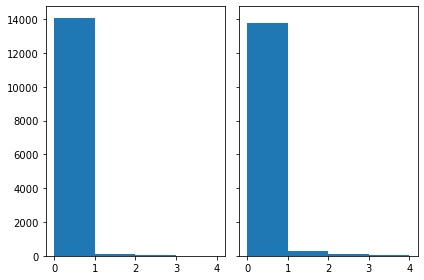

In [115]:
# Plot a graph to show that some %s are > 1
bins = np.arange(0, 5, 1)

# Generate two normal distributions
dist1 = df_firms['pct_top1']
dist2 = df_firms['pct_top5']

# Set plot object
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(dist1, bins=bins)
axs[1].hist(dist2, bins=bins)

Text(0.5, 0.98, '% of total shares held by top x managers')

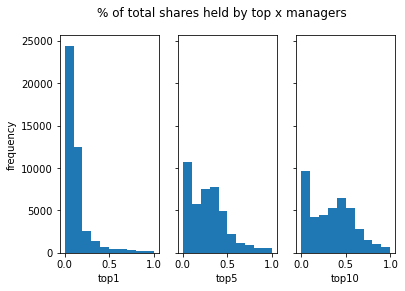

In [154]:
# Plot a histogram of '% of total shares held by top x managers'

# Set bins
bins = np.arange(0, 1.01, 0.1)

# Get the %s for each firm
dist1 = df_firms['pct_top1']
dist2 = df_firms['pct_top5']
dist3 = df_firms['pct_top10']

# Set plot object
fig, axs = plt.subplots(1, 3, sharey=True)

# Plot histograms
axs[0].hist(dist1, bins=bins)
axs[1].hist(dist2, bins=bins)
axs[2].hist(dist3, bins=bins)

# Labels
axs[0].set_xlabel('top1')
axs[1].set_xlabel('top5')
axs[2].set_xlabel('top10')
axs[0].set_ylabel('frequency')

# Title
fig.suptitle('% of total shares held by top x managers')

### another groupby

In [144]:
# Groupby with type
df_firms_type = df.groupby(['STKNAME', 'CUSIP', 'type']).agg(agg_dict).reset_index()
df_firms_type

,STKNAME,CUSIP,type,pct_top1,pct_top5,pct_top10,pct_type_top1,pct_type_top5,pct_type_top10
0,1-800-FLOWERS.COM INC,68243Q10,Bank,0.087493,0.256174,0.379131,0.023139,0.042503,0.045164
1,1-800-FLOWERS.COM INC,68243Q10,Insurance,0.087493,0.256174,0.379131,0.006831,0.008799,0.008799
2,1-800-FLOWERS.COM INC,68243Q10,Investment Advisors,0.087493,0.256174,0.379131,0.040896,0.091046,0.110282
3,1-800-FLOWERS.COM INC,68243Q10,Mutual Funds,0.087493,0.256174,0.379131,0.005769,0.005769,0.005769
4,1-800-FLOWERS.COM INC,68243Q10,Others,0.087493,0.256174,0.379131,0.087493,0.250241,0.331940
...,...,...,...,...,...,...,...,...,...
43814,ZYNGA INC,98986T10,Bank,0.101914,0.328623,0.461763,0.016026,0.041061,0.050959
43815,ZYNGA INC,98986T10,Insurance,0.101914,0.328623,0.461763,0.003953,0.005616,0.005617
43816,ZYNGA INC,98986T10,Investment Advisors,0.101914,0.328623,0.461763,0.079353,0.190871,0.222840
43817,ZYNGA INC,98986T10,Mutual Funds,0.101914,0.328623,0.461763,0.003760,0.007513,0.007579


In [151]:
# Get a pivoted version of each of the 3 df['pct_type']s, where each row = a firm, and each col = a firm type. 
# Then each df = data for 1 of the 3 options: top_1, top_5, and top_10.

df_type_top1 = df_firms_type[['STKNAME', 'CUSIP', 'type', 'pct_top1']].pivot(index='CUSIP', columns='type', values='pct_top1')
df_type_top5 = df_firms_type[['STKNAME', 'CUSIP', 'type', 'pct_top5']].pivot(index='CUSIP', columns='type', values='pct_top5')
df_type_top10 = df_firms_type[['STKNAME', 'CUSIP', 'type', 'pct_top10']].pivot(index='CUSIP', columns='type', values='pct_top10')
df_type_top1

type,Bank,Insurance,Investment Advisors,Mutual Funds,Others
CUSIP,,,,,
00030410,NaN,NaN,NaN,NaN,0.000341
00032Q10,0.087556,NaN,0.087556,NaN,0.087556
00036020,0.120698,0.120698,0.120698,0.120698,0.120698
00036110,0.159699,0.159699,0.159699,0.159699,0.159699
00037520,0.009455,0.009455,0.009455,0.009455,0.009455
...,...,...,...,...,...
Y9717H10,NaN,NaN,NaN,NaN,0.000072
Y9727F10,NaN,NaN,0.000011,NaN,NaN
Y982AC10,NaN,NaN,0.000030,NaN,NaN


Index(['Bank', 'Insurance', 'Investment Advisors', 'Mutual Funds', 'Others'], dtype='object', name='type')

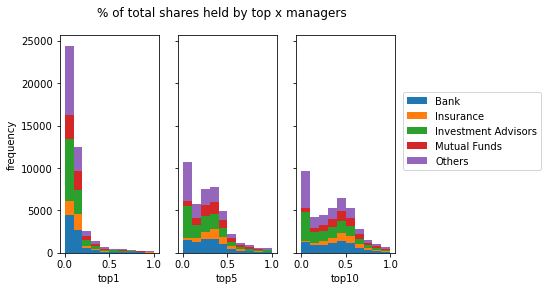

In [197]:
# Plot a histogram of '% of total shares held by top x managers, colored by type'
# Set bins
bins = np.arange(0, 1.01, 0.1)

# Set plot object
fig, axs = plt.subplots(1, 3, sharey=True)

# Plot histograms
axs[0].hist(df_type_top1, bins=bins, density=False, histtype='bar', stacked=True)
axs[1].hist(df_type_top5, bins=bins, density=False, histtype='bar', stacked=True)
axs[2].hist(df_type_top10, bins=bins, density=False, histtype='bar', stacked=True)

# Labels
axs[0].set_xlabel('top1')
axs[1].set_xlabel('top5')
axs[2].set_xlabel('top10')
axs[0].set_ylabel('frequency')

# Title
fig.suptitle('% of total shares held by top x managers')

# Legends
fig.legend(labels = df_type_top1.columns, bbox_to_anchor = (1.25, 0.7))

In [ ]:
# Reference
agg_dict = {'Nationality Mix':lambda x:most_common_nationalities(x)}
# Note: CompanyID and CompanyID + Company Name both gave same number of rows
df_with_nationality_groupby_firm = df_with_nationality.groupby(['CompanyID*', 'Company Name']).agg(agg_dict).reset_index()
df_with_nationality_groupby_firm 